# Kaggle Shelter Animal Outcomes

https://www.kaggle.com/c/shelter-animal-outcomes

The data comes from Austin Animal Center from October 1st, 2013 to March, 2016. Outcomes represent the status of animals as they leave the Animal Center. All animals receive a unique Animal ID during intake. 

In this competition, you are going to predict the outcome of the animal as they leave the Animal Center. These outcomes include: Adoption, Died, Euthanasia, Return to owner, and Transfer. 

The train and test data are randomly split. 

In [264]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [265]:
import pandas as pd

train = pd.read_csv('train.csv.gz')

In [266]:
train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [267]:
len(train)

26729

In [268]:
train.isnull().sum()/train.size

AnimalID          0.000000
Name              0.028774
DateTime          0.000000
OutcomeType       0.000000
OutcomeSubtype    0.050926
AnimalType        0.000000
SexuponOutcome    0.000004
AgeuponOutcome    0.000067
Breed             0.000000
Color             0.000000
dtype: float64

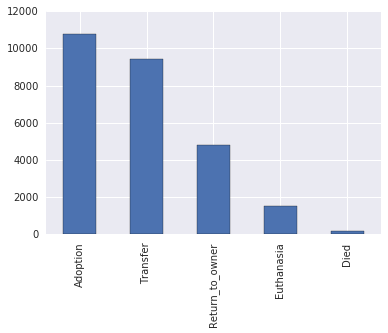

In [269]:
train['OutcomeType'].value_counts().plot(kind='bar')

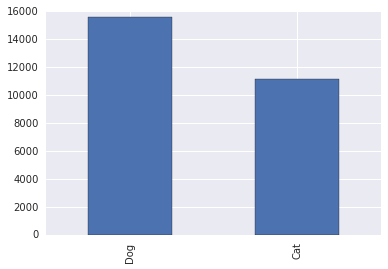

In [273]:
train['AnimalType'].value_counts().plot(kind='bar')

In [462]:
def extract_features(dataset):
    import re
    import numpy as np
    def AgeuponOutcome2Age(age):
        if pd.isnull(age):
            return age
        assert type(age) is str, age
        m = re.match(r'(\d+)\s+(\w+)', age)

        scale = {
            'day': 1,
            'week': 7,
            'month': 30,
            'year': 365,
        }
        number = int(m.groups(0)[0])
        interval = m.groups(0)[1]
        interval = interval if not interval.endswith('s') else interval[:-1] 
        return number*scale[interval]
    dataset['Age'] = dataset['AgeuponOutcome'].map(AgeuponOutcome2Age)
    dataset['Age'] = dataset['Age'].fillna(dataset['Age'].median())
    
    dataset['Adult'] = (dataset['Age'] > 365).astype(int)
    
    dataset['AnimalType'] = dataset['AnimalType'].fillna('Dog')
    
    dataset['CatOrDog'] = dataset['AnimalType'].map(lambda x: {'Cat': 0, 'Dog': 1}[x])
    
    dataset['HasName'] = (~dataset['Name'].isnull()).astype(int)

    def MaleFemale(sex):
        if pd.isnull(sex):
            return sex
        if 'Male' in sex:
            return 1
        if 'Female' in sex:
            return 0
        return np.nan

    dataset['Sex'] = dataset['SexuponOutcome'].map(MaleFemale)
    dataset['Sex'] = dataset['Sex'].fillna(1)

    def Intact(sex):
        if pd.isnull(sex):
            return np.nan
        if 'Intact' in sex:
            return 1
        if 'Neutered' in sex or 'Spayed' in sex:
            return 0
        return np.nan

    dataset['Intact'] = dataset['SexuponOutcome'].map(Intact)
    dataset['Intact'] = dataset['Intact'].fillna(0)
    
    dataset['BreedMix'] = dataset['Breed'].map(lambda b: int('Mix' in b))
    
    dataset['year'] = dataset['DateTime'].map(lambda t: pd.to_datetime(t).year)
    
    dataset['month'] = dataset['DateTime'].map(lambda t: pd.to_datetime(t).month)
    
    dataset['season'] = dataset['month'].map(lambda m: [0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 0, 0][m - 1])

    dataset['hour'] = dataset['DateTime'].map(lambda t: pd.to_datetime(t).hour)
    
    def extract_second_color(color):
        parts = color.split('/')
        return parts[1] if len(parts) > 1 else np.nan

    dataset['SimpleColor'] = dataset['Color'].map(lambda c: c.split('/')[0].split(' ')[0])

    return dataset

train = extract_features(train)

In [463]:
targets_encoder = {}
targets_decoder = {}
for i, target in enumerate(train['OutcomeType'].unique()):
    targets_encoder[target] = i
    targets_decoder[i] = target
train['OutcomeTypeEncoded'] = train["OutcomeType"].map(lambda t: targets_encoder[t])

In [464]:
train.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,BreedMix,year,month,FirstColor,SecondColor,OutcomeTypeEncoded,season,Adult,hour,SimpleColor
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,...,1,2014,2,Brown,White,0,1,0,18,Brown
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,...,1,2013,10,Cream Tabby,None,1,3,0,12,Cream
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,...,1,2015,1,Blue,White,2,0,1,12,Blue
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,...,1,2014,7,Blue Cream,None,3,2,0,19,Blue
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,...,0,2013,11,Tan,None,3,0,1,12,Tan


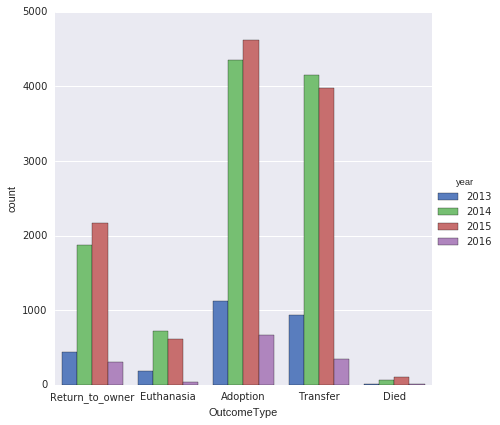

In [465]:
g = sns.factorplot(x="OutcomeType", hue="year", data=train,
                   size=6, kind="count", palette="muted")

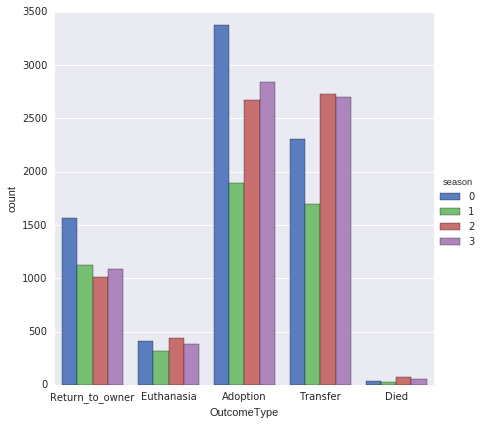

In [466]:
g = sns.factorplot(x="OutcomeType", hue="season", data=train,
                   size=6, kind="count", palette="muted")

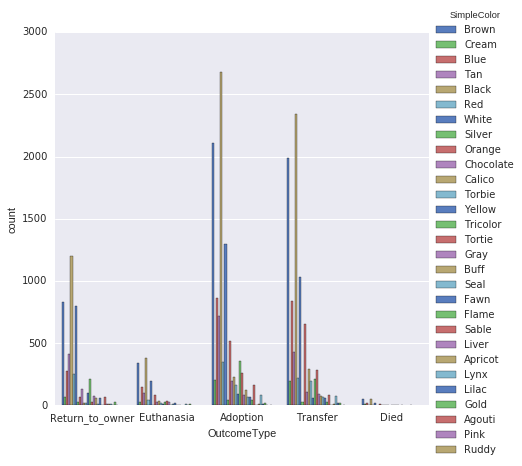

In [468]:
g = sns.factorplot(x="OutcomeType", hue="SimpleColor", data=train,
                   size=6, kind="count", palette="muted")

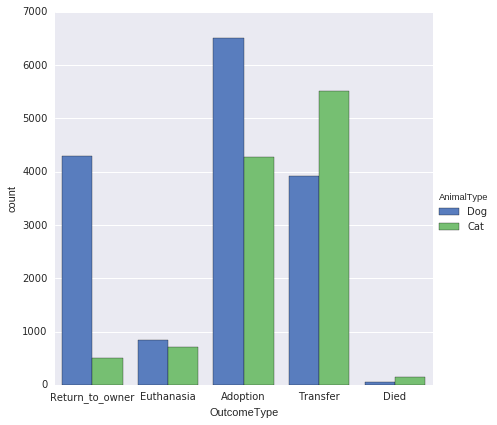

In [469]:
g = sns.factorplot(x="OutcomeType", hue="AnimalType", data=train,
                   size=6, kind="count", palette="muted")

In [473]:
from sklearn.feature_extraction import DictVectorizer
vec = DictVectorizer(sparse=False)
colors = vec.fit_transform(train[['SimpleColor']].T.to_dict().values())

In [476]:
from sklearn.cross_validation import train_test_split

features = [
    'CatOrDog',
    'Age',
#     'Adult',
    'HasName',
    'Sex',
    'Intact',
    'BreedMix',
    'year',
    'month',
    'hour',
    'season',
#     'SimpleColor',
]
targets = 'OutcomeTypeEncoded'

train_features = train[features]
train_features = np.hstack((train_features, colors))
X_train, X_test, y_train, y_test = train_test_split(train_features, train[targets], test_size=0.1, random_state=42)

best_n_estimators: 290, score: 1.01503955627


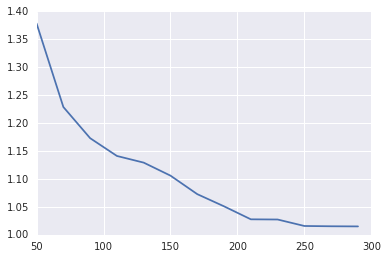

In [492]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression

train_results = {
    'n_estimators_range': range(50, 300, 20),
    'scores': [],
}

for n_estimators in train_results['n_estimators_range']:
    estimator = RandomForestClassifier(n_estimators=n_estimators, random_state=241)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict_proba(X_test)
    train_results['scores'].append(log_loss(y_test, y_pred))

plt.plot(train_results['n_estimators_range'], train_results['scores'])
best_n_estimators = train_results['n_estimators_range'][np.argmin(train_results['scores'])]
print("best_n_estimators: {}, score: {}".format(best_n_estimators, np.min(train_results['scores'])))

In [496]:
estimator = RandomForestClassifier(n_estimators=best_n_estimators)
estimator.fit(train[features], train[targets])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=290, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

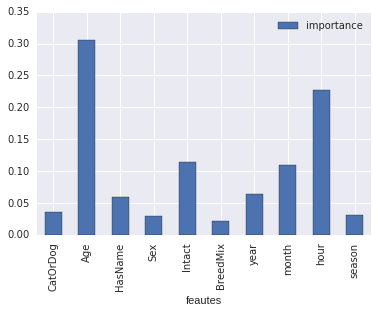

In [497]:
feature_impotance = pd.DataFrame({'feautes': features, 'importance': estimator.feature_importances_}).set_index('feautes')
feature_impotance.plot(kind='bar')
# indices = np.argsort(estimator.feature_importances_)[::-1]
# plt.bar(x = features[indices], y = estimator.feature_importances_)

In [483]:
test = pd.read_csv('test.csv.gz')

In [484]:
test = extract_features(test)

y_pred = estimator.predict_proba(test[features])

In [485]:
pred = pd.DataFrame(data={'ID': test['ID'].values, 'OutcomeType':np.argmax(y_pred, axis=1)})
pred['OutcomeType'] = pred['OutcomeType'].map(lambda t: targets_decoder[t])
for target_column in train['OutcomeType'].unique():
    pred[target_column] = y_pred[:, targets_encoder[target_column]]
pred.head()

,ID,OutcomeType,Return_to_owner,Euthanasia,Adoption,Transfer,Died
0,1,Transfer,0.076667,0.016667,0.006667,0.900000,0.0
1,2,Adoption,0.003333,0.000000,0.996667,0.000000,0.0
2,3,Adoption,0.091667,0.050000,0.466250,0.392083,0.0
3,4,Transfer,0.066667,0.050000,0.050000,0.833333,0.0
4,5,Return_to_owner,0.670385,0.000000,0.329615,0.000000,0.0


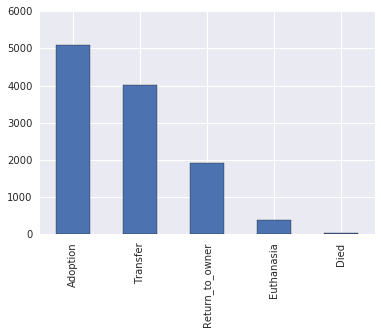

In [486]:
pred['OutcomeType'].value_counts().plot(kind='bar')

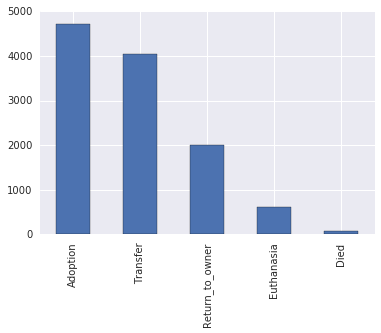

In [487]:
pred[['Adoption', 'Transfer', 'Return_to_owner', 'Euthanasia', 'Died']].sum().plot(kind='bar')


In [488]:
pred.to_csv('pred.csv', index=False, columns=['ID', 'Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'])